In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

# Replace with your file path
# file_path = '/content/drive/My Drive/binned_df.csv'
file_path = '../data/binned_df.csv'

binned_df = pd.read_csv(file_path)

# Print some info
binned_df.head()

,Unnamed: 0,MAP,diastolic_bp,systolic_bp,urine,ALT,AST,p_f_ratio,lactic_acid,serum_creatinine,GCS_total,fluid_boluses,vasopressors,PatientID,Timepoints
0,0,3,1,2,2,0,0,0,0,0,3,0,0,0,0
1,1,2,1,2,2,0,0,1,0,0,3,0,0,0,1
2,2,3,1,2,2,0,0,0,0,0,3,0,0,0,2
3,3,0,1,1,2,0,0,1,0,0,3,0,0,0,3
4,4,2,2,1,2,1,0,0,0,0,3,0,0,0,4


In [4]:
# state and action columns
binned_state_columns = ['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total']
action_columns = ['fluid_boluses', 'vasopressors']

def create_transitions(df):
    X = []
    y = []
    patients = df['PatientID'].unique()

    for patient in patients:
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        for i in range(len(patient_records) - 1):
            current_state = patient_records.iloc[i][binned_state_columns]
            next_state = patient_records.iloc[i + 1][binned_state_columns]
            action = patient_records.iloc[i][action_columns]
            X.append(np.concatenate([current_state, action]))
            y.append(next_state)
    return pd.DataFrame(X, columns=binned_state_columns + action_columns), pd.DataFrame(y, columns=binned_state_columns)

# create transitions (model-based --> mb)
X_mb, y_mb = create_transitions(binned_df)

In [5]:
#use K nearest neighbours to calculate next state prediction (function approximation for transitions)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_mb_train, X_mb_test, y_mb_train, y_mb_test = train_test_split(X_mb, y_mb, test_size=0.2, random_state=42)
knn_models = {col: KNeighborsClassifier(n_neighbors=20) for col in binned_state_columns}

for col in binned_state_columns:
    knn_models[col].fit(X_mb_train, y_mb_train[col])

#evaluate accuracy
predictions = pd.DataFrame()
for col in binned_state_columns:
    predictions[col] = knn_models[col].predict(X_mb_test)
    accuracy = accuracy_score(y_mb_test[col], predictions[col])
    print(f"Accuracy for predicting {col}: {accuracy:.2f}")

Accuracy for predicting MAP: 0.50
Accuracy for predicting diastolic_bp: 0.69
Accuracy for predicting systolic_bp: 0.68
Accuracy for predicting urine: 0.71
Accuracy for predicting ALT: 0.81
Accuracy for predicting AST: 0.80
Accuracy for predicting lactic_acid: 0.93
Accuracy for predicting serum_creatinine: 0.85
Accuracy for predicting p_f_ratio: 0.63
Accuracy for predicting GCS_total: 0.89


In [6]:
# reward function for binned values
def get_unbinned_MAP(binned_MAP):
    """
    Convert binned MAP values to representative unbinned values
    MAP bins: 0: <55, 1: 55-60, 2: 60-65, 3: >65
    Using conservative (lower) values for each bin
    """
    MAP_values = {
        0: 50,  # For <55, use 50 as representative
        1: 55,  # For 55-60, use 55
        2: 60,  # For 60-65, use 60
        3: 65   # For >65, use 65
    }
    return MAP_values[binned_MAP]

def get_unbinned_urine(binned_urine):
    """
    Convert binned urine values to representative unbinned values
    Urine bins: 0: <30, 1: 30-50, 2: >50
    Using conservative (lower) values for each bin
    """
    urine_values = {
        0: 25,  # For <30, use 25 as representative
        1: 30,  # For 30-50, use 30
        2: 50   # For >50, use 50
    }
    return urine_values[binned_urine]

def calculate_reward(MAP, urine):
    """Calculate reward based on unbinned MAP and urine values"""
    # First check the special case for urine and MAP
    if urine > 30 and MAP > 55:
        return 0

    # Otherwise, calculate reward based on MAP piecewise function
    if MAP > 65:
        return 0
    elif 60 < MAP <= 65:
        return (-0.05 * (65 - MAP)) / 5
    elif 55 < MAP <= 60:
        return (-0.1 * (60 - MAP)) / 5 - 0.05
    else:  # MAP <= 55
        return (-0.85 * (55 - MAP)) / 15 - 0.15

def calculate_reward_from_binned(binned_MAP, binned_urine):
    """Calculate reward using binned values by converting to unbinned first"""
    unbinned_MAP = get_unbinned_MAP(binned_MAP)
    unbinned_urine = get_unbinned_urine(binned_urine)
    return calculate_reward(unbinned_MAP, unbinned_urine)

In [7]:
# get reward
binned_df["reward"] = binned_df.apply(lambda row: calculate_reward_from_binned(row["MAP"], row["urine"]), axis=1)

# get action
binned_df['action_number'] = 4 * binned_df['fluid_boluses'] + binned_df['vasopressors']

In [8]:
#train test split
seed = 42
np.random.seed(seed)
train_ratio = 0.8
num_patients = binned_df['PatientID'].nunique()
num_train_samples = int(num_patients * train_ratio)

train_ids = np.random.choice(num_patients, num_train_samples, replace=False)
train_mb_df = binned_df[binned_df["PatientID"].isin(train_ids)].reset_index(drop=True)
test_mb_df = binned_df[~binned_df["PatientID"].isin(train_ids)].reset_index(drop=True)

print(f'Train Data: {train_mb_df.shape}')
print(f'Test Data: {test_mb_df.shape}')

Train Data: (150144, 17)
Test Data: (37536, 17)


In [9]:
import random
from tqdm import tqdm

# get dictionary
train_state_dict = {tuple(row): idx for idx, row in enumerate(train_mb_df[binned_state_columns].drop_duplicates().values)}

# helper functions
def get_state_index(row, state_columns=binned_state_columns):
    return train_state_dict[tuple(row[state_columns])]

def find_closest_index(input_tuple, train_state_dict=train_state_dict):
    closest_index = None
    min_distance = float("inf")

    # Convert input tuple to numeric array
    input_array = np.array(input_tuple).astype(float)

    for state_tuple, index in train_state_dict.items():
        # Convert state tuple to numeric array
        state_array = np.array(state_tuple).astype(float)

        # Calculate Euclidean distance
        distance = np.linalg.norm(state_array - input_array)

        if distance < min_distance:
            min_distance = distance
            closest_index = index

    return closest_index

state_size = len(train_state_dict)
action_size = 16

# return state action pair
def return_state_action_df(row, fluid, vaso):
    state_action = {}
    for col in binned_state_columns:
        state_action[col] = row[col].item()

    state_action["fluid_boluses"] = fluid
    state_action["vasopressors"] = vaso
    return pd.DataFrame([state_action])

def clinician_cumulative_reward(df, gamma=0.99):
    patients = df["PatientID"].unique()

    total_cumulative_reward = 0
    rewards = []

    for patient in patients:
        patient_reward = 0
        patient_records = df[df['PatientID']==patient].reset_index(drop=True)
        for i in range(len(patient_records) - 1): # 0 to 47 (exclusive of 47)
            reward = patient_records.iloc[i]["reward"].item()
            # times gamma (for patient trajectory)
            patient_reward += (gamma ** i) * reward

        rewards.append(patient_reward)
        total_cumulative_reward += patient_reward

    return total_cumulative_reward, rewards

In [10]:
# reward function for binned values
def get_unbinned_MAP(binned_MAP):
    """
    Convert binned MAP values to representative unbinned values
    MAP bins: 0: <55, 1: 55-60, 2: 60-65, 3: >65
    Using conservative (lower) values for each bin
    """
    MAP_values = {
        0: 50,  # For <55, use 50 as representative
        1: 55,  # For 55-60, use 55
        2: 60,  # For 60-65, use 60
        3: 65   # For >65, use 65
    }
    return MAP_values[binned_MAP]

def get_unbinned_urine(binned_urine):
    """
    Convert binned urine values to representative unbinned values
    Urine bins: 0: <30, 1: 30-50, 2: >50
    Using conservative (lower) values for each bin
    """
    urine_values = {
        0: 25,  # For <30, use 25 as representative
        1: 30,  # For 30-50, use 30
        2: 50   # For >50, use 50
    }
    return urine_values[binned_urine]

def calculate_reward(MAP, urine):
    """Calculate reward based on unbinned MAP and urine values"""
    # First check the special case for urine and MAP
    if urine > 30 and MAP > 55:
        return 0

    # Otherwise, calculate reward based on MAP piecewise function
    if MAP > 65:
        return 0
    elif 60 < MAP <= 65:
        return (-0.05 * (65 - MAP)) / 5
    elif 55 < MAP <= 60:
        return (-0.1 * (60 - MAP)) / 5 - 0.05
    else:  # MAP <= 55
        return (-0.85 * (55 - MAP)) / 15 - 0.15

def calculate_reward_from_binned(binned_MAP, binned_urine):
    """Calculate reward using binned values by converting to unbinned first"""
    unbinned_MAP = get_unbinned_MAP(binned_MAP)
    unbinned_urine = get_unbinned_urine(binned_urine)
    return calculate_reward(unbinned_MAP, unbinned_urine)


class DynaQAgent:
    def __init__(self, state_size, action_size, knn_models, gamma=0.99, alpha=0.1, planning_steps=10):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.alpha = alpha
        self.planning_steps = planning_steps
        self.q_table = np.full((state_size, action_size), np.nan, dtype='float')
        self.knn_models = knn_models
        self.observed_pairs = set()
        self.state_row_cache = {}

    def initialize_q_values(self, train_df):
        """Initialize Q-values and state row cache efficiently"""
        min_reward = np.min(train_df["reward"])

        # Pre-compute state row cache more efficiently
        state_groups = train_df.groupby(binned_state_columns).first()
        for state_tuple, row in state_groups.iterrows():
            state_idx = train_state_dict[state_tuple]
            self.state_row_cache[state_idx] = pd.Series(state_tuple, index=binned_state_columns)

        # Initialize Q-values efficiently
        states = train_df.apply(lambda row: get_state_index(row), axis=1).values
        actions = train_df['action_number'].astype(int).values

        # Initialize all to NaN first
        self.q_table.fill(np.nan)

        # Set min_reward for observed pairs
        for state, action in zip(states, actions):
            self.q_table[state, action] = min_reward
            self.observed_pairs.add((state, action))

        print(f"Initialized {len(self.observed_pairs)} state-action pairs")
        print(f"Cached {len(self.state_row_cache)} unique states")

    def predict_next_state(self, state_row, action):
        """Use KNN models to predict next state"""
        fluid = action // 4
        vaso = action % 4

        state_action_df = return_state_action_df(state_row, fluid, vaso)

        predicted_state = {}
        for col in binned_state_columns:
            predicted_state[col] = self.knn_models[col].predict(state_action_df)[0]

        return predicted_state

    def calculate_reward(self, predicted_state):
        """Calculate reward based on predicted state"""
        return calculate_reward_from_binned(
            predicted_state['MAP'],
            predicted_state['urine']
        )

    def update(self, state, action, reward, next_state):
        """Update Q-values"""
        next_max_q = np.nanmax(self.q_table[next_state, :])
        self.q_table[state, action] += self.alpha * (
            reward + self.gamma * next_max_q - self.q_table[state, action]
        )


def precompute_transitions(train_df):
    """
    Precompute all valid transitions from the training data.

    Args:
        train_df: DataFrame containing training data

    Returns:
        dict: Dictionary of patient transitions
        list: List of observed state-action pairs
    """
    print("Precomputing transitions...")

    # Initialize containers
    patient_transitions = {}
    observed_pairs = set()

    # Process each patient
    for patient_id in tqdm(train_df['PatientID'].unique()):
        patient_data = train_df[train_df['PatientID'] == patient_id].sort_values('Timepoints')
        patient_transitions[patient_id] = []

        for i in range(len(patient_data) - 1):
            current_row = patient_data.iloc[i]
            next_row = patient_data.iloc[i + 1]

            if current_row['Timepoints'] < 47:
                # Get state indices and action
                current_state = get_state_index(current_row)
                next_state = get_state_index(next_row)
                action = int(current_row['action_number'])

                # Store transition
                patient_transitions[patient_id].append({
                    'state': current_state,
                    'action': action,
                    'reward': current_row['reward'],
                    'next_state': next_state
                })

                # Add to observed pairs
                observed_pairs.add((current_state, action))

    print(f"Processed {len(patient_transitions)} patients")
    print(f"Found {len(observed_pairs)} unique state-action pairs")

    return patient_transitions, list(observed_pairs)


In [11]:
def train_dynaQ_orig(agent, patient_transitions, observed_pairs, num_iterations=100):
    """
    DynaQ training with planning steps after each transition.
    """
    print("Starting DynaQ training...")
    diff_tracker = np.zeros(num_iterations)
    unseen_states_count = 0

    # Pre-compute and cache data
    planning_samples = np.array(observed_pairs)
    state_tuple_to_idx = {tuple(agent.state_row_cache[idx]): idx
                         for idx in agent.state_row_cache}

    for iter_num in range(num_iterations):
        q_old = agent.q_table.copy()
        total_planning_steps = 0
        total_transitions = 0

        # Process each patient's transitions
        for transitions in tqdm(patient_transitions.values(),
                              desc=f"Iteration {iter_num+1}/{num_iterations}",
                              leave=False):
            # Process each real transition
            for transition in transitions:
                # Real experience update
                agent.update(
                    transition['state'],
                    transition['action'],
                    transition['reward'],
                    transition['next_state']
                )
                total_transitions += 1

                # Do planning steps after each transition
                planning_indices = np.random.randint(
                    0,
                    len(planning_samples),
                    size=agent.planning_steps
                )
                sampled_pairs = planning_samples[planning_indices]

                # Batch planning steps
                for sim_state, sim_action in sampled_pairs:
                    sim_state_row = agent.state_row_cache[sim_state]

                    # Model-based predictions
                    predicted_next_state_dict = agent.predict_next_state(
                        sim_state_row,
                        sim_action
                    )

                    predicted_state_tuple = tuple(
                        predicted_next_state_dict[col]
                        for col in binned_state_columns
                    )

                    # Fast lookup with fallback
                    predicted_next_state = state_tuple_to_idx.get(
                        predicted_state_tuple,
                        find_closest_index(predicted_state_tuple)
                    )
                    if predicted_next_state not in state_tuple_to_idx.values():
                        unseen_states_count += 1

                    # Update Q-values
                    sim_reward = agent.calculate_reward(predicted_next_state_dict)
                    agent.update(
                        sim_state,
                        sim_action,
                        sim_reward,
                        predicted_next_state
                    )
                    total_planning_steps += 1

        # Calculate difference
        valid_mask = ~np.isnan(agent.q_table)
        diff = np.mean(np.abs(agent.q_table[valid_mask] - q_old[valid_mask]))
        diff_tracker[iter_num] = diff

        # Print info every 5 iterations
        #if (iter_num + 1) % 5 == 0:
        print(f"\n[Step {iter_num+1}/{num_iterations}]")
        print(f"  Q-value difference: {diff:.6f}")
        print(f"  Planning steps: {total_planning_steps}")
        print(f"  Real transitions: {total_transitions}")
        print(f"  Unseen states: {unseen_states_count}")

    return agent, diff_tracker

def train_dynaQ(agent, patient_transitions, observed_pairs, num_iterations=100):
    """
    DynaQ training with planning steps after each patient's transitions.
    """
    print("Starting DynaQ training...")
    diff_tracker = np.zeros(num_iterations)
    unseen_states_count = 0

    # Pre-compute and cache data
    planning_samples = np.array(observed_pairs)
    state_tuple_to_idx = {tuple(agent.state_row_cache[idx]): idx
                         for idx in agent.state_row_cache}

    for iter_num in range(num_iterations):
        q_old = agent.q_table.copy()
        total_planning_steps = 0

        # Process each patient's transitions
        for transitions in tqdm(patient_transitions.values(),
                              desc=f"Iteration {iter_num+1}/{num_iterations}",
                              leave=False):
            # First process all real transitions for this patient
            for transition in transitions:
                agent.update(
                    transition['state'],
                    transition['action'],
                    transition['reward'],
                    transition['next_state']
                )

            # Then do planning steps after patient's transitions
            planning_indices = np.random.randint(
                0,
                len(planning_samples),
                size=agent.planning_steps
            )
            sampled_pairs = planning_samples[planning_indices]

            # Batch planning steps
            for sim_state, sim_action in sampled_pairs:
                sim_state_row = agent.state_row_cache[sim_state]

                # Model-based predictions
                predicted_next_state_dict = agent.predict_next_state(
                    sim_state_row,
                    sim_action
                )

                predicted_state_tuple = tuple(
                    predicted_next_state_dict[col]
                    for col in binned_state_columns
                )

                # Fast lookup with fallback
                predicted_next_state = state_tuple_to_idx.get(
                    predicted_state_tuple,
                    find_closest_index(predicted_state_tuple)
                )
                if predicted_next_state not in state_tuple_to_idx.values():
                    unseen_states_count += 1

                # Update Q-values
                sim_reward = agent.calculate_reward(predicted_next_state_dict)
                agent.update(
                    sim_state,
                    sim_action,
                    sim_reward,
                    predicted_next_state
                )
                total_planning_steps += 1

        # Calculate difference
        valid_mask = ~np.isnan(agent.q_table)
        diff = np.mean(np.abs(agent.q_table[valid_mask] - q_old[valid_mask]))
        diff_tracker[iter_num] = diff

        # Print info every 5 iterations
        #if (iter_num + 1) % 5 == 0:
        print(f"\n[Step {iter_num+1}/{num_iterations}]")
        print(f"  Q-value difference: {diff:.6f}")
        print(f"  Planning steps: {total_planning_steps}")
        print(f"  Unseen states: {unseen_states_count}")

    return agent, diff_tracker

In [12]:
# Precompute transitions
patient_transitions, observed_pairs = precompute_transitions(train_mb_df)

Precomputing transitions...


100%|██████████| 3128/3128 [02:26<00:00, 21.32it/s]

Processed 3128 patients
Found 18175 unique state-action pairs


In [20]:
# Initialize agent
dynaq_agent = DynaQAgent(state_size=state_size, action_size=action_size,
                   knn_models=knn_models, gamma=0.99, alpha=0.1, planning_steps=5)
dynaq_agent.initialize_q_values(train_mb_df)

Initialized 18282 state-action pairs
Cached 10912 unique states


In [21]:
### CELINE

import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def train_dynaQ_orig(agent, patient_transitions, observed_pairs, num_iterations=100):
    """
    DynaQ training with planning steps after each transition.
    """
    print("Starting DynaQ training...")
    diff_tracker = np.zeros(num_iterations)
    unseen_states_count = 0

    # Pre-compute and cache data
    planning_samples = np.array(observed_pairs)
    state_tuple_to_idx = {tuple(agent.state_row_cache[idx]): idx
                         for idx in agent.state_row_cache}

    for iter_num in range(num_iterations):
        q_old = agent.q_table.copy()
        total_planning_steps = 0
        total_transitions = 0

        # Collect updates for batch processing
        updates = []
        
        # Process each patient's transitions
        for transitions in tqdm(patient_transitions.values(),
                              desc=f"Iteration {iter_num+1}/{num_iterations}",
                              leave=False):
            for transition in transitions:
                updates.append((transition['state'], transition['action'], transition['reward'], transition['next_state']))
                total_transitions += 1

        # Process all updates in a batch
        for state, action, reward, next_state in updates:
            agent.update(state, action, reward, next_state)

        # Do planning steps after all real transitions
        planning_indices = np.random.randint(
            0,
            len(planning_samples),
            size=agent.planning_steps
        )
        sampled_pairs = planning_samples[planning_indices]

        # Parallelize planning steps
        def process_planning_step(sim_state, sim_action):
            sim_state_row = agent.state_row_cache[sim_state]
            predicted_next_state_dict = agent.predict_next_state(sim_state_row, sim_action)
            predicted_state_tuple = tuple(predicted_next_state_dict[col] for col in binned_state_columns)
            predicted_next_state = state_tuple_to_idx.get(predicted_state_tuple, find_closest_index(predicted_state_tuple))
            return sim_state, sim_action, predicted_next_state, predicted_next_state_dict

        results = Parallel(n_jobs=-1)(delayed(process_planning_step)(sim_state, sim_action) for sim_state, sim_action in sampled_pairs)

        for sim_state, sim_action, predicted_next_state, predicted_next_state_dict in results:
            if predicted_next_state not in state_tuple_to_idx.values():
                unseen_states_count += 1
            sim_reward = agent.calculate_reward(predicted_next_state_dict)
            agent.update(sim_state, sim_action, sim_reward, predicted_next_state)
            total_planning_steps += 1

        # Calculate difference
        valid_mask = ~np.isnan(agent.q_table)
        diff = np.mean(np.abs(agent.q_table[valid_mask] - q_old[valid_mask]))
        diff_tracker[iter_num] = diff

        print(f"\n[Step {iter_num+1}/{num_iterations}]")
        print(f"  Q-value difference: {diff:.6f}")
        print(f"  Planning steps: {total_planning_steps}")
        print(f"  Real transitions: {total_transitions}")
        print(f"  Unseen states: {unseen_states_count}")

    # Plotting the convergence
    plt.figure(figsize=(10, 5))
    plt.plot(diff_tracker[:iter_num + 1], marker='o')
    plt.title('Convergence of DynaQ Agent')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Absolute Q-value Difference')
    plt.axhline(y=0, color='r', linestyle='--', label='Convergence Threshold (0)')
    plt.grid()
    plt.legend()
    plt.show()

    return agent, diff_tracker




In [27]:
### CELINE

import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def train_dynaQ_batch(agent, patient_transitions, observed_pairs, num_iterations=100, batch_size=10):
    """
    DynaQ training with planning steps after a batch of transitions.
    """
    print("Starting DynaQ training...")
    diff_tracker = np.zeros(num_iterations)
    unseen_states_count = 0

    # Pre-compute and cache data
    planning_samples = np.array(observed_pairs)
    state_tuple_to_idx = {tuple(agent.state_row_cache[idx]): idx
                         for idx in agent.state_row_cache}

    for iter_num in range(num_iterations):
        q_old = agent.q_table.copy()
        total_planning_steps = 0
        total_transitions = 0

        # Collect updates for batch processing
        updates = []
        
        # Process each patient's transitions
        for transitions in tqdm(patient_transitions.values(),
                              desc=f"Iteration {iter_num+1}/{num_iterations}",
                              leave=False):
            for transition in transitions:
                updates.append((transition['state'], transition['action'], transition['reward'], transition['next_state']))
                total_transitions += 1

                # If the batch size is reached, process the batch
                if len(updates) == batch_size:
                    # Process all updates in the batch
                    for state, action, reward, next_state in updates:
                        agent.update(state, action, reward, next_state)

                    # Perform planning steps after the batch
                    planning_indices = np.random.randint(
                        0,
                        len(planning_samples),
                        size=agent.planning_steps
                    )
                    sampled_pairs = planning_samples[planning_indices]

                    # Parallelize planning steps
                    results = Parallel(n_jobs=-1)(delayed(process_planning_step)(sim_state, sim_action, agent, state_tuple_to_idx) for sim_state, sim_action in sampled_pairs)

                    for sim_state, sim_action, predicted_next_state, predicted_next_state_dict in results:
                        if predicted_next_state not in state_tuple_to_idx.values():
                            unseen_states_count += 1
                        sim_reward = agent.calculate_reward(predicted_next_state_dict)
                        agent.update(sim_state, sim_action, sim_reward, predicted_next_state)
                        total_planning_steps += 1

                    # Clear the updates after processing
                    updates = []

        # Process any remaining transitions in the last batch
        if updates:
            for state, action, reward, next_state in updates:
                agent.update(state, action, reward, next_state)

            # Perform planning steps after the last batch
            planning_indices = np.random.randint(
                0,
                len(planning_samples),
                size=agent.planning_steps
            )
            sampled_pairs = planning_samples[planning_indices]

            # Parallelize planning steps
            results = Parallel(n_jobs=-1)(delayed(process_planning_step)(sim_state, sim_action, agent, state_tuple_to_idx) for sim_state, sim_action in sampled_pairs)

            for sim_state, sim_action, predicted_next_state, predicted_next_state_dict in results:
                if predicted_next_state not in state_tuple_to_idx.values():
                    unseen_states_count += 1
                sim_reward = agent.calculate_reward(predicted_next_state_dict)
                agent.update(sim_state, sim_action, sim_reward, predicted_next_state)
                total_planning_steps += 1

        # Calculate difference
        valid_mask = ~np.isnan(agent.q_table)
        diff = np.mean(np.abs(agent.q_table[valid_mask] - q_old[valid_mask]))
        diff_tracker[iter_num] = diff

        print(f"\n[Step {iter_num+1}/{num_iterations}]")
        print(f"  Q-value difference: {diff:.6f}")
        print(f"  Planning steps: {total_planning_steps}")
        print(f"  Real transitions: {total_transitions}")
        print(f"  Unseen states: {unseen_states_count}")

    # Plotting the convergence
    plt.figure(figsize=(10, 5))
    plt.plot(diff_tracker[:iter_num + 1], marker='o')
    plt.title('Convergence of DynaQ Agent')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Absolute Q-value Difference')
    plt.axhline(y=0, color='r', linestyle='--', label='Convergence Threshold (0)')
    plt.grid()
    plt.legend()
    plt.show()

    return agent, diff_tracker

def process_planning_step(sim_state, sim_action, agent, state_tuple_to_idx):
    sim_state_row = agent.state_row_cache[sim_state]
    predicted_next_state_dict = agent.predict_next_state(sim_state_row, sim_action)
    predicted_state_tuple = tuple(predicted_next_state_dict[col] for col in binned_state_columns)
    predicted_next_state = state_tuple_to_idx.get(predicted_state_tuple, find_closest_index(predicted_state_tuple))
    return sim_state, sim_action, predicted_next_state, predicted_next_state_dict

Starting DynaQ training...



[Step 1/100]
  Q-value difference: 0.007251
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 2/100]
  Q-value difference: 0.003114
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 3/100]
  Q-value difference: 0.002194
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 4/100]
  Q-value difference: 0.001715
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 5/100]
  Q-value difference: 0.001419
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 6/100]
  Q-value difference: 0.001211
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 7/100]
  Q-value difference: 0.001057
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 8/100]
  Q-value difference: 0.000944
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 9/100]
  Q-value difference: 0.000856
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 10/100]
  Q-value difference: 0.000788
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 11/100]
  Q-value difference: 0.000734
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 12/100]
  Q-value difference: 0.000690
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 13/100]
  Q-value difference: 0.000658
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 14/100]
  Q-value difference: 0.000623
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 15/100]
  Q-value difference: 0.000600
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 16/100]
  Q-value difference: 0.000580
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 17/100]
  Q-value difference: 0.000562
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 18/100]
  Q-value difference: 0.000543
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 19/100]
  Q-value difference: 0.000529
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 20/100]
  Q-value difference: 0.000523
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 21/100]
  Q-value difference: 0.000511
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 22/100]
  Q-value difference: 0.000508
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 23/100]
  Q-value difference: 0.000493
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 24/100]
  Q-value difference: 0.000493
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 25/100]
  Q-value difference: 0.000489
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 26/100]
  Q-value difference: 0.000483
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 27/100]
  Q-value difference: 0.000477
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 28/100]
  Q-value difference: 0.000478
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 29/100]
  Q-value difference: 0.000482
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 30/100]
  Q-value difference: 0.000476
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 31/100]
  Q-value difference: 0.000473
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 32/100]
  Q-value difference: 0.000475
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 33/100]
  Q-value difference: 0.000473
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 34/100]
  Q-value difference: 0.000478
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 35/100]
  Q-value difference: 0.000488
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 36/100]
  Q-value difference: 0.000480
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 37/100]
  Q-value difference: 0.000477
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 38/100]
  Q-value difference: 0.000482
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 39/100]
  Q-value difference: 0.000478
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 40/100]
  Q-value difference: 0.000481
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 41/100]
  Q-value difference: 0.000484
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 42/100]
  Q-value difference: 0.000487
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 43/100]
  Q-value difference: 0.000482
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 44/100]
  Q-value difference: 0.000484
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 45/100]
  Q-value difference: 0.000488
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 46/100]
  Q-value difference: 0.000490
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 47/100]
  Q-value difference: 0.000488
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 48/100]
  Q-value difference: 0.000488
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 49/100]
  Q-value difference: 0.000490
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 50/100]
  Q-value difference: 0.000494
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 51/100]
  Q-value difference: 0.000490
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 52/100]
  Q-value difference: 0.000493
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 53/100]
  Q-value difference: 0.000492
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 54/100]
  Q-value difference: 0.000495
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 55/100]
  Q-value difference: 0.000494
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 56/100]
  Q-value difference: 0.000493
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 57/100]
  Q-value difference: 0.000497
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 58/100]
  Q-value difference: 0.000497
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 59/100]
  Q-value difference: 0.000493
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 60/100]
  Q-value difference: 0.000497
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 61/100]
  Q-value difference: 0.000493
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 62/100]
  Q-value difference: 0.000494
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 63/100]
  Q-value difference: 0.000494
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 64/100]
  Q-value difference: 0.000502
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 65/100]
  Q-value difference: 0.000495
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 66/100]
  Q-value difference: 0.000494
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 67/100]
  Q-value difference: 0.000494
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 68/100]
  Q-value difference: 0.000495
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 69/100]
  Q-value difference: 0.000501
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 70/100]
  Q-value difference: 0.000496
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 71/100]
  Q-value difference: 0.000499
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 72/100]
  Q-value difference: 0.000495
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 73/100]
  Q-value difference: 0.000499
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 74/100]
  Q-value difference: 0.000494
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 75/100]
  Q-value difference: 0.000498
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 76/100]
  Q-value difference: 0.000501
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 77/100]
  Q-value difference: 0.000496
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 78/100]
  Q-value difference: 0.000493
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 79/100]
  Q-value difference: 0.000499
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 80/100]
  Q-value difference: 0.000498
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 81/100]
  Q-value difference: 0.000507
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 82/100]
  Q-value difference: 0.000500
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 83/100]
  Q-value difference: 0.000500
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 84/100]
  Q-value difference: 0.000500
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 85/100]
  Q-value difference: 0.000496
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 86/100]
  Q-value difference: 0.000499
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 87/100]
  Q-value difference: 0.000500
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 88/100]
  Q-value difference: 0.000497
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 89/100]
  Q-value difference: 0.000502
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 90/100]
  Q-value difference: 0.000502
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 91/100]
  Q-value difference: 0.000510
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 92/100]
  Q-value difference: 0.000512
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 93/100]
  Q-value difference: 0.000506
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 94/100]
  Q-value difference: 0.000501
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 95/100]
  Q-value difference: 0.000497
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 96/100]
  Q-value difference: 0.000498
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 97/100]
  Q-value difference: 0.000496
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 98/100]
  Q-value difference: 0.000495
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 99/100]
  Q-value difference: 0.000501
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0



[Step 100/100]
  Q-value difference: 0.000498
  Planning steps: 5
  Real transitions: 147016
  Unseen states: 0


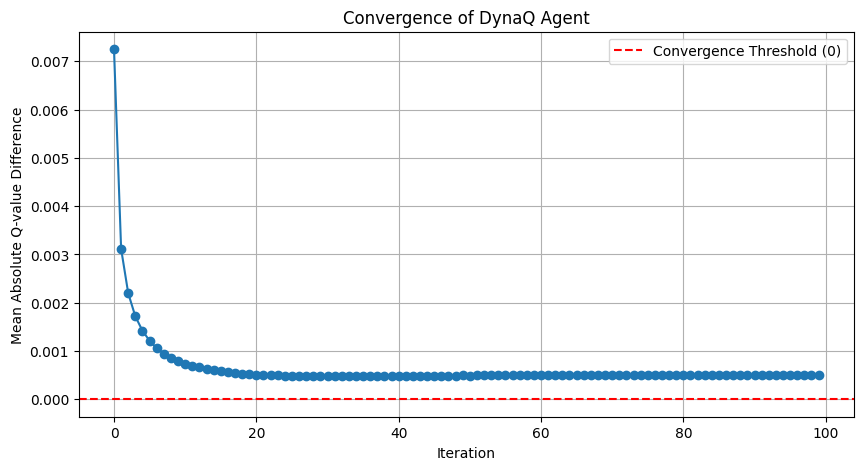

In [29]:
# Train agent
dynaq_agent, diff_tracker = train_dynaQ_orig(dynaq_agent, patient_transitions, observed_pairs, num_iterations=100)

In [24]:
# save agent
import pickle
save_path = '../models/DynaQ/dynaq_agent_iteration.pkl'

with open(save_path, 'wb') as file:
    pickle.dump(dynaq_agent, file)